<a href="https://colab.research.google.com/github/yylonly/ServeNet/blob/stacked-bert/ServeNet/ServeNet_TF1.5_Keras_GPU_GoogleDrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os

if os.path.isdir("/content/drive/My Drive/ServeNet"):
  os.chdir("/content/drive/My Drive/ServeNet")
else: 
  !git clone https://github.com/yylonly/ServeNet.git
  os.chdir("/content/drive/My Drive/ServeNet")

In [0]:
!ls -l 

total 51
drwx------ 2 root root 4096 Nov 22 16:59 AdaBoost_Net
drwx------ 2 root root 4096 Nov 22 16:59 Colab
drwx------ 2 root root 4096 Nov 22 16:59 Data
-rw------- 1 root root  311 Nov 22 16:59 Dockerfile
drwx------ 2 root root 4096 Nov 22 16:59 LDA_SVM_Net
drwx------ 2 root root 4096 Nov 22 16:59 Naive_Bayes_Net
drwx------ 2 root root 4096 Nov 22 16:59 Random_Forest_Net
-rw------- 1 root root 1794 Nov 22 16:59 README.md
drwx------ 2 root root 4096 Nov 22 16:59 Result
drwx------ 2 root root 4096 Nov 22 16:59 ServeNet
-rw------- 1 root root 3296 Nov 22 19:19 ServeNetHistory
-rw------- 1 root root 1191 Nov 22 19:22 ServeNetLoss.pdf
-rw------- 1 root root 1191 Nov 22 19:19 ServeNetTop1.pdf
-rw------- 1 root root 1191 Nov 22 19:22 ServeNetTop5.pdf
drwx------ 2 root root 4096 Nov 22 16:59 Utils
drwx------ 2 root root 4096 Nov 22 16:59 WebScrapyForAPI


In [0]:
# compatible with keras
from tensorflow import keras
import numpy as np

import tensorflow as tf
tf.keras.backend.clear_session()

print("Tensorflow version " + tf.__version__)

Tensorflow version 1.15.0


In [0]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=128) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /job:localhost/replica:0/task:0/device:GPU:0
Number of accelerators:  1


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import h5py
import pandas as pd

#from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Conv2D, Reshape, Average
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.initializers import Orthogonal

%matplotlib inline

In [0]:
h5f = h5py.File('Data/SplittedPaddedIndexedServiceDataset.h5','r') 
X_train = h5f['indexed_padded_Train_X'][:]
Y_train = h5f['Train_Y_one_hot'][:]
X_test = h5f['indexed_padded_Test_X'][:]
Y_test = h5f['Test_Y_one_hot'][:]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
h5f.close()

(8123, 110) (8123, 50)
(2061, 110) (2061, 50)


In [0]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf-8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [0]:
if not os.path.isfile("Data/glove.6B.200d.txt"):
  !wget http://nlp.stanford.edu/data/glove.6B.zip -P Data
  !unzip Data/glove.6B.zip -d Data

In [0]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('Data/glove.6B.200d.txt')

In [0]:
# GRADED FUNCTION: pretrained_embedding_layer

def trainable_embedding_layer():
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        embedding_vector = word_to_vec_map.get(word)
        if embedding_vector is not None:
            emb_matrix[index, :] = embedding_vector

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer


In [0]:
# val_top_k_categorical_accuracy: 0.8845

def ServeNet(input_shape):
    """
    Function creating the ServeNet model
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = trainable_embedding_layer()
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices) 
     
    embeddings = Reshape((110, 200, 1))(embeddings)
    
    features1 = Conv2D(64, kernel_size=(3, 3), padding='same')(embeddings)
    features2 = Conv2D(1, kernel_size=(1, 1), padding='same')(features1)
    features = Reshape((110, 200))(features2)
     
    print(features)
      
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = Bidirectional(LSTM(512, return_sequences=False))(features)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(200, activation='tanh')(X)
    X = Dropout(0.2)(X)
    X = Dense(50, activation='softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [0]:
maxLen = 110
with strategy.scope():
    model = ServeNet((maxLen, ))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Tensor("reshape_1/Reshape:0", shape=(?, 110, 200), dtype=float32)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 110)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 110, 200)          80000200  
_________________________________________________________________
reshape (Reshape)            (None, 110, 200, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 110, 200, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 200, 1)       65        
_________________________________________________________________
reshape_1 (Reshape)          (None, 110, 200)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              292044

In [0]:
checkpointer = ModelCheckpoint(filepath='Data/ServeNet.hdf5', monitor='val_top_k_categorical_accuracy', verbose=1, save_best_only=True)

In [0]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0)

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[metrics.top_k_categorical_accuracy, metrics.categorical_accuracy])

In [0]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 64, verbose = 1, shuffle=False, callbacks=[checkpointer])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 8123 samples, validate on 2061 samples
Epoch 1/20
8064/8123 [============================>.] - ETA: 0s - loss: 3.1506 - top_k_categorical_accuracy: 0.4653 - categorical_accuracy: 0.2066
Epoch 00001: val_top_k_categorical_accuracy improved from -inf to 0.70500, saving model to Data/ServeNet.hdf5
8123/8123 [==============================] - 93s 11ms/sample - loss: 3.1472 - top_k_categorical_accuracy: 0.4661 - categorical_accuracy: 0.2072 - val_loss: 2.3016 - val_top_k_categorical_accuracy: 0.7050 - val_categorical_accuracy: 0.3906
Epoch 2/20
8064/8123 [============================>.] - ETA: 0s - loss: 2.0880 - top_k_categorical_accuracy: 0.7515 - categorical_accuracy: 0.4492
Epoch 00002: val_top_k_categorical_accuracy improved from 0.70500 to 0.82193, saving model to Data/ServeNet.hdf5
8123/8123 [==============================] - 85s 10ms/sample - loss: 2.0854 - top_k_categorical_accura

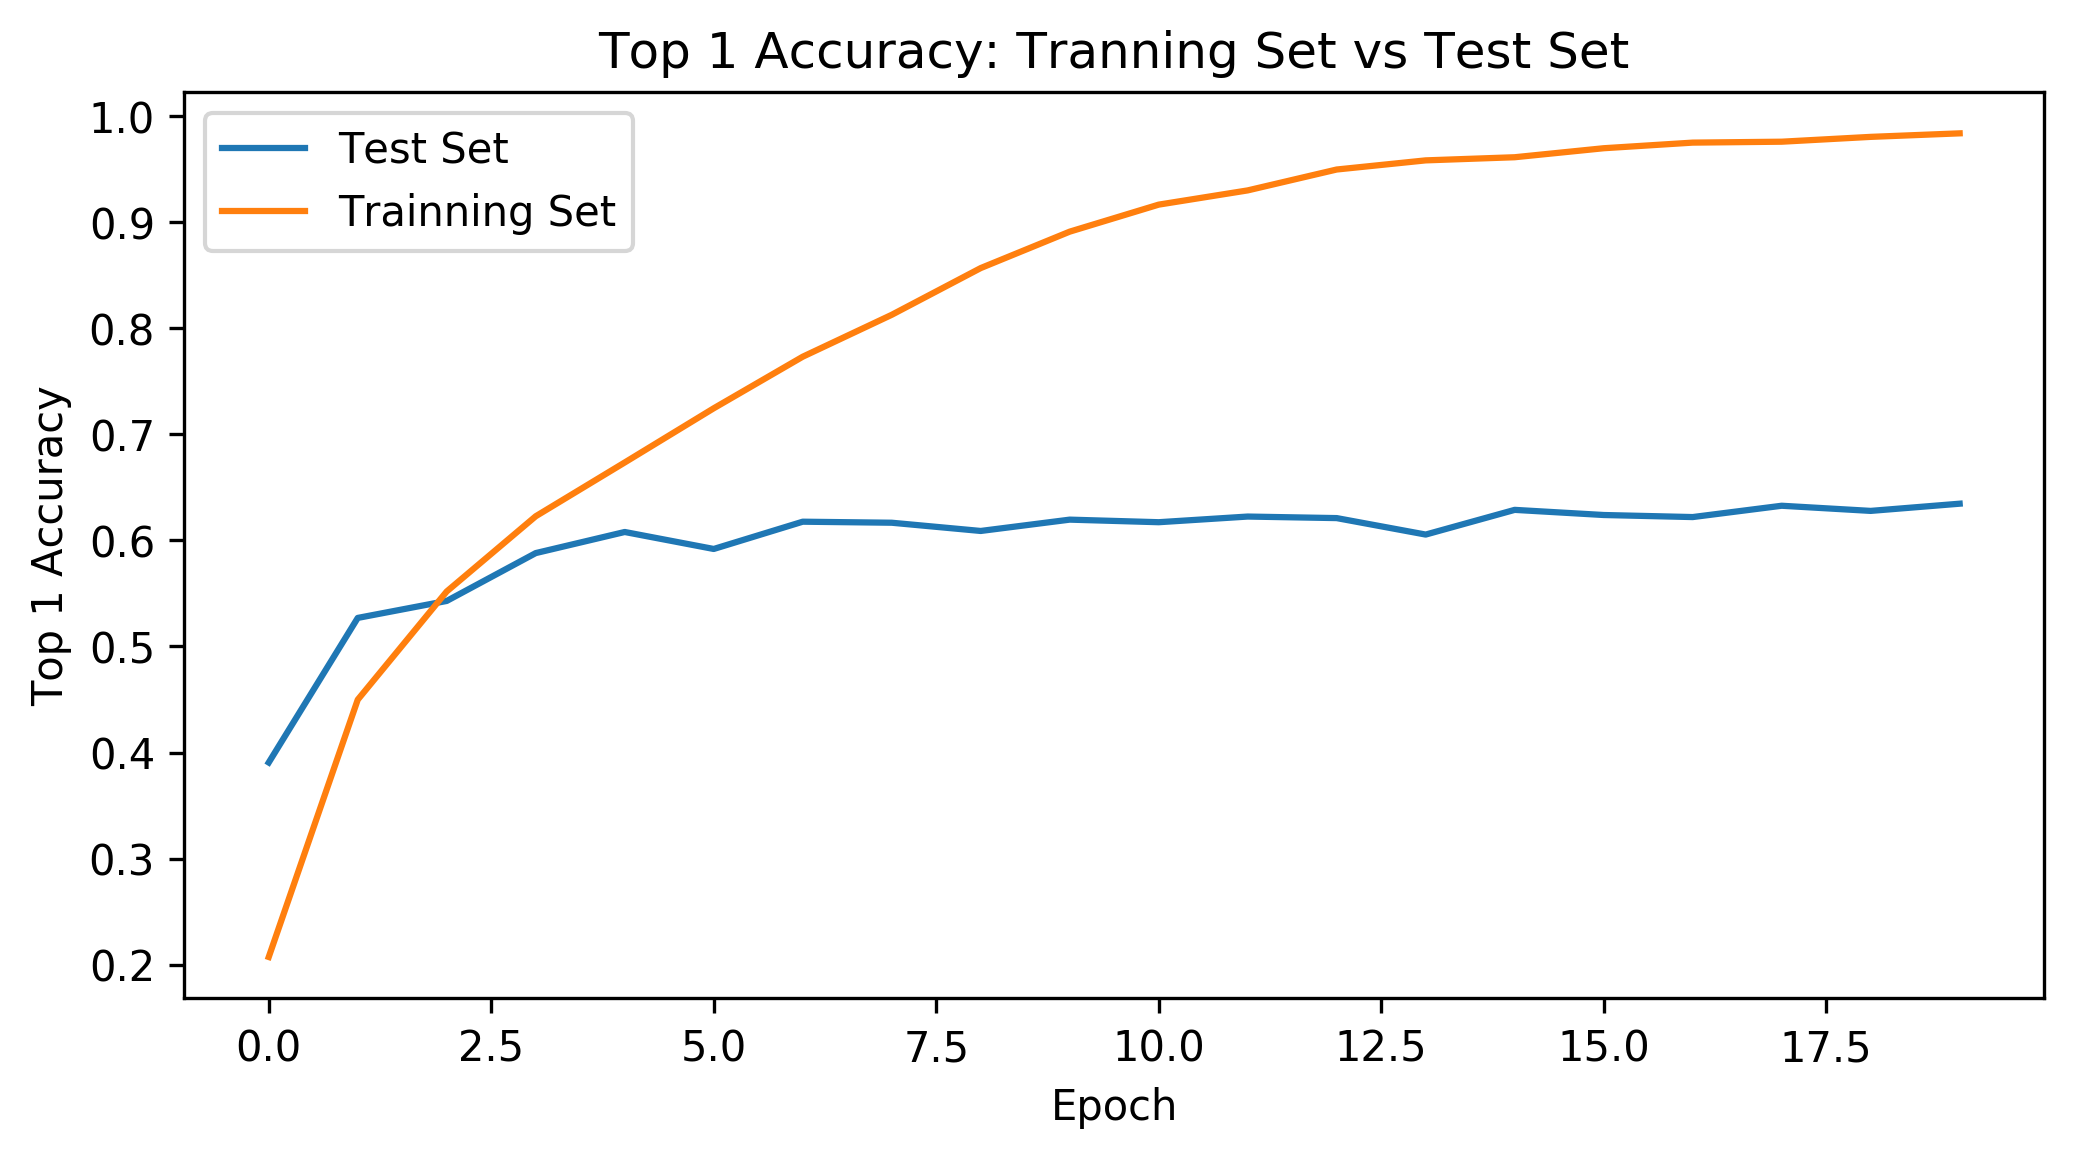

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 1 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 1 Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Test Set")
plt.plot(history.history['categorical_accuracy'], label="Trainning Set")
plt.legend()
plt.show()
plt.savefig('ServeNetTop1.pdf', format='pdf', dpi=300)

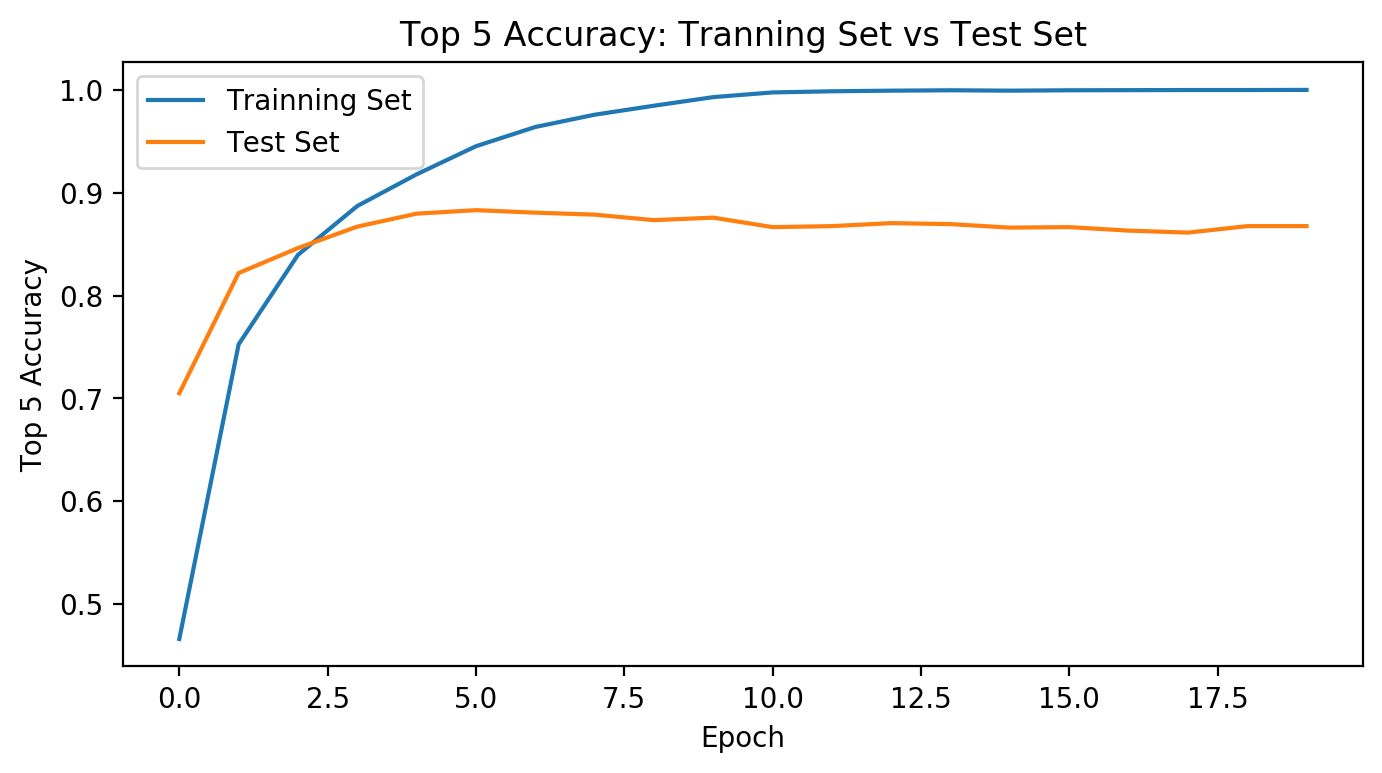

<Figure size 432x288 with 0 Axes>

In [0]:

# plot metrics
plt.figure(figsize=(8, 4), dpi=200)
plt.title("Top 5 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 5 Accuracy")
plt.plot(history.history['top_k_categorical_accuracy'], label="Trainning Set")
plt.plot(history.history['val_top_k_categorical_accuracy'], label="Test Set")
plt.legend()
plt.show()
plt.savefig('ServeNetTop5.pdf', format='pdf', dpi=300)

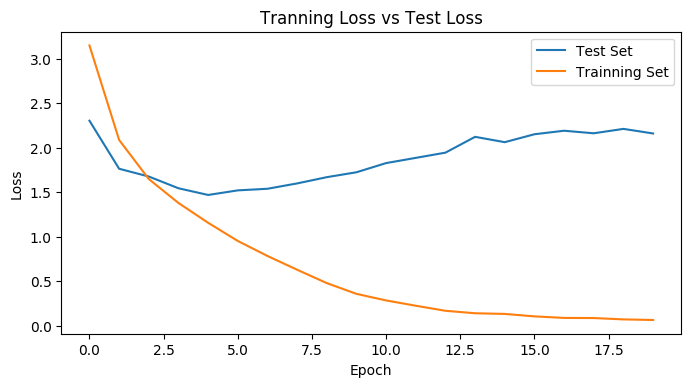

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Tranning Loss vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['val_loss'], label="Test Set")
plt.plot(history.history['loss'], label="Trainning Set")
plt.legend()
plt.show()
plt.savefig('ServeNetLoss.pdf', format='pdf', dpi=300)

In [0]:
import pickle
  
f = open('ServeNetHistory', 'wb')
pickle.dump(history.history, f)
f.close()

In [0]:
import pickle

f = open('ServeNetHistory', 'rb')
his = pickle.load(f)
f.close()

In [0]:
val_top_k = his['val_top_k_categorical_accuracy']
print("top5: ", max(val_top_k))
print(np.argmax(val_top_k))
val_loss = his['val_loss']
print("loss: ", min(val_loss))
print(np.argmin(val_loss))
val_ca = his['val_categorical_accuracy']
print("top1: ", max(val_ca))
print(np.argmax(val_ca))

top5:  0.8830665
5
loss:  1.4672892213966706
4
top1:  0.6346434
19


In [0]:
model = load_model('Data/ServeNet.hdf5')

In [0]:
print("Training set:")
loss_train, top5error_train, top1error_train = model.evaluate(X_train, Y_train)
print("Top5 Training accuracy = ", top5error_train)
print("Top1 Training accuracy = ", top1error_train)
print('Test set:')
loss_test, top5error_test, top1error_test = model.evaluate(X_test, Y_test)
print("Training accuracy = ", top5error_test)
print("Top1 Training accuracy = ", top1error_test)

Training set:
8123/8123 [==============================] - 43s 5ms/sample - loss: 0.6454 - top_k_categorical_accuracy: 0.9724 - categorical_accuracy: 0.8083
Top5 Training accuracy =  0.972424
Top1 Training accuracy =  0.8083221
Test set:
2061/2061 [==============================] - 11s 5ms/sample - loss: 1.5189 - top_k_categorical_accuracy: 0.8831 - categorical_accuracy: 0.5919
Training accuracy =  0.8830665
Top1 Training accuracy =  0.59194565


In [0]:
C = 50
predY_test = model.predict(X_test)
print(predY_test.shape)
print(Y_test.shape)

(2061, 50)
(2061, 50)
